# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Shows plots in jupyter notebook
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from scipy import signal
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler
import time
from sklearn.tree import plot_tree # tree diagram
from collections import Counter

---
## 2. Load data

In [46]:
client_df = pd.read_csv('client_data.csv')
client_df["date_activ"] = pd.to_datetime(client_df["date_activ"], format='%Y-%m-%d')
client_df["date_end"] = pd.to_datetime(client_df["date_end"], format='%Y-%m-%d')
client_df["date_modif_prod"] = pd.to_datetime(client_df["date_modif_prod"], format='%Y-%m-%d')
client_df["date_renewal"] = pd.to_datetime(client_df["date_renewal"], format='%Y-%m-%d')

In [47]:
client_df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0


---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [48]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [49]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [50]:
diff

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001
...,...,...,...
16091,ffef185810e44254c3a4c6395e6b4d8a,-0.050232,-0.335085
16092,fffac626da707b1b5ab11e8431a4d0a2,-0.003778,0.177779
16093,fffc0cacd305dd51f316424bbb08d1bd,-0.001760,0.164916
16094,fffe4f5646aa39c7f97f95ae2679ce64,-0.009391,0.162916


### Encode cat features

In [51]:
client_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              14606 non-null  object        
 1   channel_sales                   14606 non-null  object        
 2   cons_12m                        14606 non-null  int64         
 3   cons_gas_12m                    14606 non-null  int64         
 4   cons_last_month                 14606 non-null  int64         
 5   date_activ                      14606 non-null  datetime64[ns]
 6   date_end                        14606 non-null  datetime64[ns]
 7   date_modif_prod                 14606 non-null  datetime64[ns]
 8   date_renewal                    14606 non-null  datetime64[ns]
 9   forecast_cons_12m               14606 non-null  float64       
 10  forecast_cons_year              14606 non-null  int64         
 11  fo

In [52]:
client_df['channel_sales'] = client_df['channel_sales'].astype('category')
client_df['cons_12m'] = client_df['cons_12m'].astype('int64')
client_df['has_gas'] = client_df['has_gas'].astype('category')
client_df['channel_sales'] = client_df['channel_sales'].astype('category')
client_df['origin_up'] = client_df['origin_up'].astype('category')

In [53]:
client_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              14606 non-null  object        
 1   channel_sales                   14606 non-null  category      
 2   cons_12m                        14606 non-null  int64         
 3   cons_gas_12m                    14606 non-null  int64         
 4   cons_last_month                 14606 non-null  int64         
 5   date_activ                      14606 non-null  datetime64[ns]
 6   date_end                        14606 non-null  datetime64[ns]
 7   date_modif_prod                 14606 non-null  datetime64[ns]
 8   date_renewal                    14606 non-null  datetime64[ns]
 9   forecast_cons_12m               14606 non-null  float64       
 10  forecast_cons_year              14606 non-null  int64         
 11  fo

In [54]:
client_df['channel_sales'] = client_df['channel_sales'].cat.codes
client_df['origin_up'] = client_df['origin_up'].cat.codes
client_df['has_gas'] = client_df['has_gas'].cat.codes
client_df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,4,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,1,0.00,25.44,25.44,2,678.99,3,4,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,0,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0,0.00,16.38,16.38,1,18.89,6,2,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,4,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0,0.00,28.60,28.60,1,6.60,6,2,13.856,0
3,bba03439a292a1e166f80264c16191cb,5,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0,0.00,30.22,30.22,1,25.46,6,2,13.200,0
4,149d57cf92fc41cf94415803a877cb4b,0,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0,52.32,44.91,44.91,1,47.98,6,2,19.800,0


### Datetime
Create a new column contains the number of month that the contract lasts.

In [55]:
client_df['contract_duration']=((client_df['date_end']-client_df['date_activ'])/ np.timedelta64(1,'M')).astype(int)
client_df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,contract_duration
0,24011ae4ebbe3035111d65fa7c15bc57,4,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.00,25.44,25.44,2,678.99,3,4,43.648,1,36
1,d29c2c54acc38ff3c0614d0a653813dd,0,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.00,16.38,16.38,1,18.89,6,2,13.800,0,84
2,764c75f661154dac3a6c254cd082ea7d,4,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.00,28.60,28.60,1,6.60,6,2,13.856,0,72
3,bba03439a292a1e166f80264c16191cb,5,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.00,30.22,30.22,1,25.46,6,2,13.200,0,72
4,149d57cf92fc41cf94415803a877cb4b,0,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,52.32,44.91,44.91,1,47.98,6,2,19.800,0,73


In order to eliminate datetime features, we set a reference data and calculate the date differences between those datetime features for taking replace of the original features. The ref. date was set as 2016-01-01.

In [56]:
def calculatemonth(referencetime,dataframe,column):
    time_diff=referencetime-dataframe[column]
    months=(time_diff/np.timedelta64(1,'M')).astype(int)
    return months

referencetime=pd.to_datetime('2016-01-01')

client_df['activ_diff']=calculatemonth(referencetime,client_df,'date_activ')
client_df['end_diff']=calculatemonth(referencetime,client_df,'date_end')
client_df['modif_diff']=calculatemonth(referencetime,client_df,'date_modif_prod')
client_df['renewal_diff']=calculatemonth(referencetime,client_df,'date_renewal')

#Remove the date columns 
client_df.drop(columns=['date_activ','date_end','date_modif_prod','date_renewal'],axis=1,inplace=True)

client_df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,net_margin,num_years_antig,origin_up,pow_max,churn,contract_duration,activ_diff,end_diff,modif_diff,renewal_diff
0,24011ae4ebbe3035111d65fa7c15bc57,4,0,54946,0,0.00,0,0.0,1.78,0.114481,...,678.99,3,4,43.648,1,36,30,-5,2,6
1,d29c2c54acc38ff3c0614d0a653813dd,0,4660,0,0,189.95,0,0.0,16.27,0.145711,...,18.89,6,2,13.800,0,84,76,-7,76,4
2,764c75f661154dac3a6c254cd082ea7d,4,544,0,0,47.96,0,0.0,38.72,0.165794,...,6.60,6,2,13.856,0,72,68,-3,68,8
3,bba03439a292a1e166f80264c16191cb,5,1584,0,0,240.04,0,0.0,19.83,0.146694,...,25.46,6,2,13.200,0,72,69,-2,69,9
4,149d57cf92fc41cf94415803a877cb4b,0,4425,0,526,445.75,526,0.0,131.73,0.116900,...,47.98,6,2,19.800,0,73,71,-2,71,9


### Log Transformation
According to the previous EDA, we found that the most numerical features are skewed. We ultilise log transformation to transfer the distributions of these features to a normal distribution.

In [57]:
def log_trans(df, col_name,n):
    df.loc[df[col_name]<0,col_name]=np.nan
    df[col_name]=df[col_name].dropna()
    df['log_'+col_name]=df[col_name].apply(lambda x:np.log(1+x))
    sns.distplot(df['log_'+col_name],ax = axes[n])

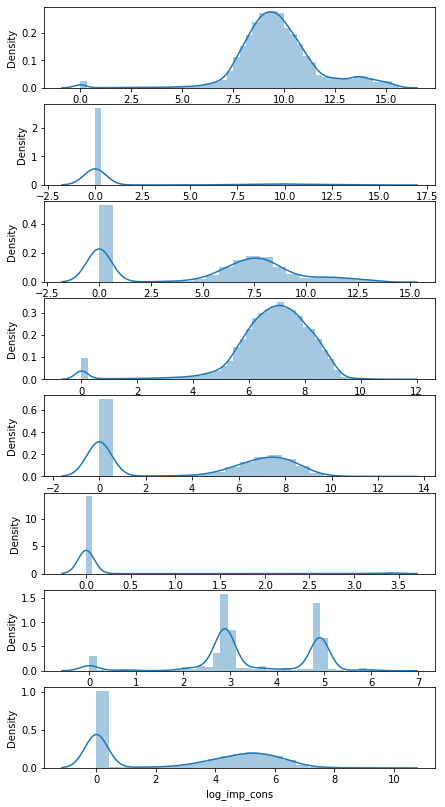

In [58]:
f, axes = plt.subplots(8, 1, figsize=(7, 14))
log_trans(client_df,'cons_12m',0)
log_trans(client_df,'cons_gas_12m',1)
log_trans(client_df,'cons_last_month',2)
log_trans(client_df,'forecast_cons_12m',3)
log_trans(client_df,'forecast_cons_year',4)
log_trans(client_df,'forecast_discount_energy',5)
log_trans(client_df,'forecast_meter_rent_12m',6)
log_trans(client_df,'imp_cons',7)

In [59]:
client_df=client_df.drop(['cons_12m','cons_gas_12m','cons_last_month','forecast_cons_12m','forecast_cons_year','forecast_discount_energy','forecast_meter_rent_12m','imp_cons'],axis=1)
client_df.head()

,id,channel_sales,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,...,modif_diff,renewal_diff,log_cons_12m,log_cons_gas_12m,log_cons_last_month,log_forecast_cons_12m,log_forecast_cons_year,log_forecast_discount_energy,log_forecast_meter_rent_12m,log_imp_cons
0,24011ae4ebbe3035111d65fa7c15bc57,4,0.114481,0.098142,40.606701,1,25.44,25.44,2,678.99,...,2,6,0.000000,10.914124,0.000000,0.000000,0.000000,0.0,1.022451,0.000000
1,d29c2c54acc38ff3c0614d0a653813dd,0,0.145711,0.000000,44.311378,0,16.38,16.38,1,18.89,...,76,4,8.446985,0.000000,0.000000,5.252012,0.000000,0.0,2.848971,0.000000
2,764c75f661154dac3a6c254cd082ea7d,4,0.165794,0.087899,44.311378,0,28.60,28.60,1,6.60,...,68,8,6.300786,0.000000,0.000000,3.891004,0.000000,0.0,3.681855,0.000000
3,bba03439a292a1e166f80264c16191cb,5,0.146694,0.000000,44.311378,0,30.22,30.22,1,25.46,...,69,9,7.368340,0.000000,0.000000,5.484963,0.000000,0.0,3.036394,0.000000
4,149d57cf92fc41cf94415803a877cb4b,0,0.116900,0.100015,40.606701,0,44.91,44.91,1,47.98,...,71,9,8.395252,0.000000,6.267201,6.101999,6.267201,0.0,4.888317,3.976311


## Removing Outliers
Remove outliers by ulitilising interquartile range(IQR)

In [60]:
def remove_outliers(df,col):
    df.loc[df[col]<0,col]=df[col].mean()
    q1=df[col].quantile(.25)
    q3=df[col].quantile(.75)
    iqr=q3-q1
    upper_bound=q3+(iqr*1.5)
    lower_bound=q1-(iqr*1.5)
    df=df[(lower_bound<df[col])|(df[col]<upper_bound)]

In [61]:
remove_outliers(client_df,'log_cons_12m')
remove_outliers(client_df,'log_cons_gas_12m')
remove_outliers(client_df,'log_cons_last_month')
remove_outliers(client_df,'log_forecast_cons_12m')
remove_outliers(client_df,'log_forecast_meter_rent_12m')
remove_outliers(client_df,'log_forecast_cons_year')
remove_outliers(client_df,'log_imp_cons')
remove_outliers(client_df,'log_forecast_discount_energy')
remove_outliers(client_df,'net_margin')
remove_outliers(client_df,'pow_max')

In [62]:
client_df.head()

,id,channel_sales,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,...,modif_diff,renewal_diff,log_cons_12m,log_cons_gas_12m,log_cons_last_month,log_forecast_cons_12m,log_forecast_cons_year,log_forecast_discount_energy,log_forecast_meter_rent_12m,log_imp_cons
0,24011ae4ebbe3035111d65fa7c15bc57,4,0.114481,0.098142,40.606701,1,25.44,25.44,2,678.99,...,2,6,0.000000,10.914124,0.000000,0.000000,0.000000,0.0,1.022451,0.000000
1,d29c2c54acc38ff3c0614d0a653813dd,0,0.145711,0.000000,44.311378,0,16.38,16.38,1,18.89,...,76,4,8.446985,0.000000,0.000000,5.252012,0.000000,0.0,2.848971,0.000000
2,764c75f661154dac3a6c254cd082ea7d,4,0.165794,0.087899,44.311378,0,28.60,28.60,1,6.60,...,68,8,6.300786,0.000000,0.000000,3.891004,0.000000,0.0,3.681855,0.000000
3,bba03439a292a1e166f80264c16191cb,5,0.146694,0.000000,44.311378,0,30.22,30.22,1,25.46,...,69,9,7.368340,0.000000,0.000000,5.484963,0.000000,0.0,3.036394,0.000000
4,149d57cf92fc41cf94415803a877cb4b,0,0.116900,0.100015,40.606701,0,44.91,44.91,1,47.98,...,71,9,8.395252,0.000000,6.267201,6.101999,6.267201,0.0,4.888317,3.976311


In [63]:
df = pd.merge(client_df, diff, on='id', how = 'left')
df.head()

,id,channel_sales,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,...,log_cons_12m,log_cons_gas_12m,log_cons_last_month,log_forecast_cons_12m,log_forecast_cons_year,log_forecast_discount_energy,log_forecast_meter_rent_12m,log_imp_cons,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,4,0.114481,0.098142,40.606701,1,25.44,25.44,2,678.99,...,0.000000,10.914124,0.000000,0.000000,0.000000,0.0,1.022451,0.000000,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,0,0.145711,0.000000,44.311378,0,16.38,16.38,1,18.89,...,8.446985,0.000000,0.000000,5.252012,0.000000,0.0,2.848971,0.000000,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,4,0.165794,0.087899,44.311378,0,28.60,28.60,1,6.60,...,6.300786,0.000000,0.000000,3.891004,0.000000,0.0,3.681855,0.000000,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,5,0.146694,0.000000,44.311378,0,30.22,30.22,1,25.46,...,7.368340,0.000000,0.000000,5.484963,0.000000,0.0,3.036394,0.000000,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,0,0.116900,0.100015,40.606701,0,44.91,44.91,1,47.98,...,8.395252,0.000000,6.267201,6.101999,6.267201,0.0,4.888317,3.976311,-0.006192,0.162916


# Modelling
## Pre-processing

In [98]:
y=df['churn']
X=df.drop('churn',axis=1)
X=X.drop('id',axis=1)

In [99]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14606 entries, 0 to 14605
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   channel_sales                    14606 non-null  int8   
 1   forecast_price_energy_off_peak   14606 non-null  float64
 2   forecast_price_energy_peak       14606 non-null  float64
 3   forecast_price_pow_off_peak      14606 non-null  float64
 4   has_gas                          14606 non-null  int8   
 5   margin_gross_pow_ele             14606 non-null  float64
 6   margin_net_pow_ele               14606 non-null  float64
 7   nb_prod_act                      14606 non-null  int64  
 8   net_margin                       14606 non-null  float64
 9   num_years_antig                  14606 non-null  int64  
 10  origin_up                        14606 non-null  int8   
 11  pow_max                          14606 non-null  float64
 12  contract_duration 

In [115]:
X_t, X_validation, y_t, y_validation = train_test_split(X, y, test_size=0.2, 
                                                        random_state=42) # Split validation set

## Modelling

In [116]:
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import GaussianNB 
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs=[]
    models =[('LogReg', LogisticRegression()), 
        ('RF', RandomForestClassifier ()),
        ('KNN', KNeighborsClassifier ()),
        ('SVM', SVC()), 
        ('GNB', GaussianNB()),
        ('XGB', XGBClassifier(eval_metric='mlogloss'))
            ]
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['not churn', 'churn']
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        final = pd.concat(dfs, ignore_index=True)
    return final

In [117]:
run_exps(X_t,y_t,X_validation,y_validation)

LogReg
              precision    recall  f1-score   support

   not churn       0.90      1.00      0.94      2617
       churn       0.43      0.01      0.02       305

    accuracy                           0.90      2922
   macro avg       0.66      0.50      0.48      2922
weighted avg       0.85      0.90      0.85      2922

RF
              precision    recall  f1-score   support

   not churn       0.90      1.00      0.95      2617
       churn       0.95      0.06      0.11       305

    accuracy                           0.90      2922
   macro avg       0.92      0.53      0.53      2922
weighted avg       0.91      0.90      0.86      2922

KNN
              precision    recall  f1-score   support

   not churn       0.90      0.99      0.94      2617
       churn       0.22      0.03      0.06       305

    accuracy                           0.89      2922
   macro avg       0.56      0.51      0.50      2922
weighted avg       0.83      0.89      0.85      2922

SVM
 

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model
0,0.093835,0.008178,0.907146,0.826623,0.907146,0.865015,0.649596,LogReg
1,0.061276,0.007255,0.903723,0.820404,0.903723,0.860050,0.626558,LogReg
2,0.060547,0.007652,0.898588,0.838879,0.898588,0.853424,0.621839,LogReg
3,0.062057,0.007582,0.912281,0.876761,0.912281,0.872074,0.649131,LogReg
4,0.067635,0.007523,0.896404,0.872771,0.896404,0.848678,0.636993,LogReg
5,1.812847,0.094513,0.913564,0.913831,0.913564,0.876919,0.707723,RF
6,1.855638,0.092066,0.907574,0.886022,0.907574,0.868305,0.665204,RF
7,1.776971,0.090499,0.903295,0.896615,0.903295,0.862084,0.672069,RF
8,1.845912,0.097583,0.915704,0.905016,0.915704,0.880752,0.731667,RF
9,1.633620,0.096236,0.899829,0.890022,0.899829,0.858154,0.687970,RF


In [118]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_t, y_t)

In [119]:
run_exps(X_res, y_res,X_validation,y_validation)

LogReg
              precision    recall  f1-score   support

   not churn       0.91      0.76      0.83      2617
       churn       0.15      0.35      0.21       305

    accuracy                           0.72      2922
   macro avg       0.53      0.56      0.52      2922
weighted avg       0.83      0.72      0.76      2922

RF
              precision    recall  f1-score   support

   not churn       0.91      0.98      0.94      2617
       churn       0.46      0.15      0.23       305

    accuracy                           0.89      2922
   macro avg       0.68      0.56      0.58      2922
weighted avg       0.86      0.89      0.87      2922

KNN
              precision    recall  f1-score   support

   not churn       0.91      0.70      0.79      2617
       churn       0.13      0.39      0.20       305

    accuracy                           0.67      2922
   macro avg       0.52      0.55      0.50      2922
weighted avg       0.83      0.67      0.73      2922

SVM
 

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model
0,0.165729,0.011914,0.747635,0.748243,0.747635,0.747403,0.817675,LogReg
1,0.124658,0.010088,0.766083,0.766081,0.766083,0.766080,0.834842,LogReg
2,0.136655,0.011129,0.754967,0.754957,0.754967,0.754933,0.815824,LogReg
3,0.134492,0.010330,0.762062,0.762328,0.762062,0.762052,0.819430,LogReg
4,0.131084,0.012072,0.757332,0.757337,0.757332,0.757326,0.809588,LogReg
5,3.243802,0.134822,0.944655,0.945973,0.944655,0.944626,0.981390,RF
6,3.369106,0.161245,0.953406,0.954784,0.953406,0.953362,0.985602,RF
7,3.287712,0.143610,0.950095,0.951389,0.950095,0.950036,0.984965,RF
8,3.160366,0.132254,0.956008,0.957051,0.956008,0.955994,0.985159,RF
9,3.188277,0.136106,0.954588,0.955459,0.954588,0.954571,0.986279,RF


We use SMOTE for up sample, results show that the performance was increased slightly. All the results are raw results whithout model tunning. The final performance could be better.